# Libraries import

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

import random
import cv2

from matplotlib import pyplot as plt
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import preprocess_input as preprocess_input_vggface
from keras_vggface.vggface import VGGFace
from livelossplot.tf_keras import PlotLossesCallback


# Data loading

In [154]:
# load csv with images
df = pd.read_csv('./_datasets/train.csv', index_col = 0)
# edit path to file location
df['image_path'] = df['image_path'].apply(lambda x: str.replace(x, 'train', '_datasets/train_dataset'))
df.head()

,image_path,emotion
0,./_datasets/train_dataset/anger/0.jpg,anger
1,./_datasets/train_dataset/anger/1.jpg,anger
2,./_datasets/train_dataset/anger/10.jpg,anger
3,./_datasets/train_dataset/anger/100.jpg,anger
4,./_datasets/train_dataset/anger/1000.jpg,anger


# Valence-arousal intro

<center><img src="img/valence-arousal.jpg" width="600"></center>

While our dataset doesn't have any information about Valence-Arousal parametres of given fotos, I shall use random values close to given emotions.
Typical 2D valence-arousal emotion space [Russell 1980] shown above. I will use numeric values of given emotions according to https://www.mdpi.com/1660-4601/17/22/8534/htm:

In [155]:
# fisrt number - valence, second - arousal
VA_emotions = {
    'anger':    [ 1.5, 6.72],   # гнев
    'contempt': [ 1.5, 3.75],   # презрение
    'disgust':  [ 3.5,  2.5],   # отвращение
    'fear':     [ 2.0,  6.2],   # страх
    'happy':    [ 6.6,  4.2],   # радость
    'neutral':  [ 4.0,  4.0],   # безразличие
    'sad':      [ 1.5,  1.5],   # грусть
    'surprise': [ 6.0,  6.0],   # удивление
    'uncertain':[ 3.0,  4.0]    # неопределенность
}

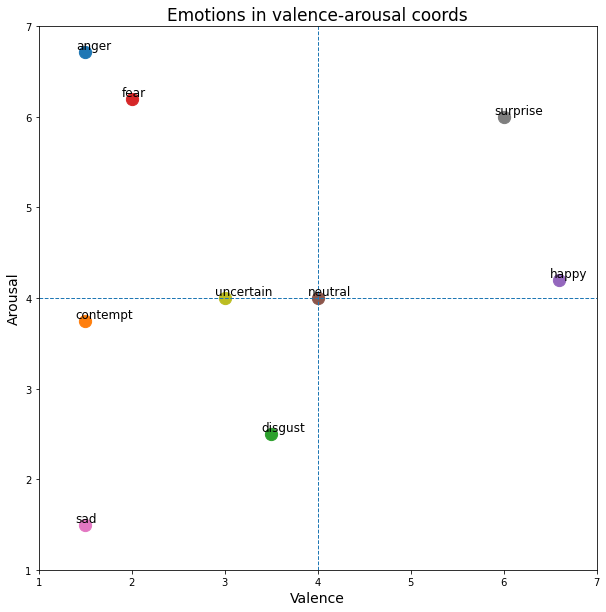

In [156]:
# drawing points of given emotions
fig, ax = plt.subplots(figsize=(10,10))
for emotion, (v, a) in VA_emotions.items():
    plt.scatter(v, a, label=emotion, s=150)
    plt.text(v-0.1, a+0.03, emotion, size=12)
plt.xlim(1,7)
plt.ylim(1,7)
plt.vlines(4, 1, 7, linestyle='dashed', lw=1)
plt.hlines(4, 1, 7, linestyle='dashed', lw=1)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.title('Emotions in valence-arousal coords', size=17)
plt.show()

In [157]:
# featuring of valence-arousal values of given foto by adding random float within (-0.22, 0.22) of base emotion value

def get_valence(emotion):
    """
    function return random valence value of given emotion
    """
    emotion_valence = VA_emotions[emotion][0] + random.uniform(-0.22, 0.22)
    return emotion_valence


def get_arousal(emotion):
    """
    function return random arousal value of given emotion
    """
    emotion_arousal = VA_emotions[emotion][1] + random.uniform(-0.22, 0.22)
    return emotion_arousal
    
df['Valence'] = df['emotion'].apply(lambda x: get_valence(x))
df['Arousal'] = df['emotion'].apply(lambda x: get_arousal(x))

df

,image_path,emotion,Valence,Arousal
0,./_datasets/train_dataset/anger/0.jpg,anger,1.349772,6.829922
1,./_datasets/train_dataset/anger/1.jpg,anger,1.484552,6.674697
2,./_datasets/train_dataset/anger/10.jpg,anger,1.518070,6.584935
3,./_datasets/train_dataset/anger/100.jpg,anger,1.405385,6.668922
4,./_datasets/train_dataset/anger/1000.jpg,anger,1.462185,6.643296
...,...,...,...,...
50041,./_datasets/train_dataset/uncertain/995.jpg,uncertain,3.096946,3.948477
50042,./_datasets/train_dataset/uncertain/996.jpg,uncertain,3.084499,4.070809
50043,./_datasets/train_dataset/uncertain/997.jpg,uncertain,2.829703,4.168604
50044,./_datasets/train_dataset/uncertain/998.jpg,uncertain,2.782555,4.035805


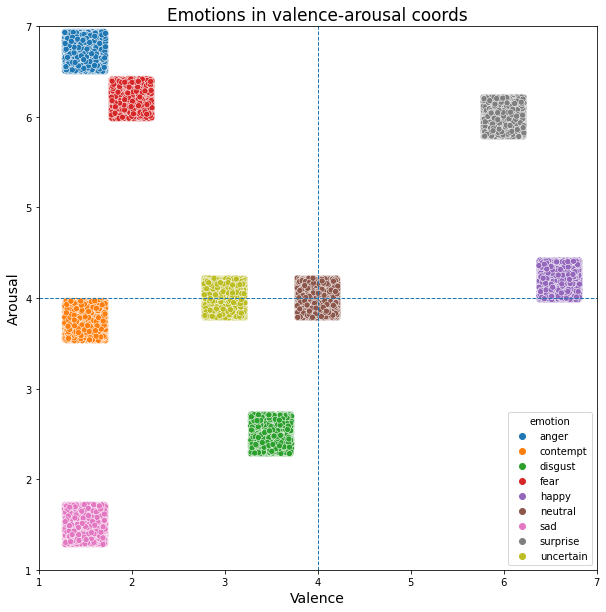

In [158]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(1,7)
plt.ylim(1,7)
plt.vlines(4, 1, 7, linestyle='dashed', lw=1)
plt.hlines(4, 1, 7, linestyle='dashed', lw=1)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.title('Emotions in valence-arousal coords', size=17)
ax = sns.scatterplot(x = 'Valence', y = 'Arousal', data = df, hue = 'emotion')
plt.show()

# DataGenerators with augmentation

In [165]:
# Important variables
BATCH_SIZE = 16
IMAGE_SIZE = 224
N_CLASSES = 9

# initialize ImageDataGenerator with augmentation
data_gen = ImageDataGenerator(featurewise_center=False,
                              brightness_range=[0.8, 1.2],
                              shear_range=0.05,
                              zoom_range=0.1,
                              fill_mode="nearest",
                              horizontal_flip=True,
                              vertical_flip=False,
                              preprocessing_function=preprocess_input_vggface,
                              validation_split=0.2)

# train and validation generator
train_data_gen = data_gen.flow_from_dataframe(dataframe = df,
                                              x_col = 'image_path',
                                              y_col = ['Valence', 'Arousal'],
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              class_mode="raw",
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              subset="training")

val_data_gen = data_gen.flow_from_dataframe(dataframe = df,
                                            x_col = 'image_path',
                                            y_col = ['Valence', 'Arousal'],
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            class_mode="raw",
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            subset="validation")


Found 40037 validated image filenames.
Found 10009 validated image filenames.


# Loading of VGGFace and fine-tuning

I use pre-trained VGGFace model with only few last layres trainable. My final model is build on VGGFace without top-layer, one flatten layer, one hidden 512 layer, dropout and one last layer with two neurons (for each prediction value) with linear activation.

In [145]:
# Load VGGFace model with RESNet
vggface_model = VGGFace(model='resnet50', include_top=False,
                        input_shape=(224, 224, 3))
vggface_model.summary()


Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_9[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_392 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [166]:
# freeze of all netword excepting last N
vggface_model.trainable = True
# last_N = 50
# for layer in vggface_model.layers[:178-last_N]:
#     layer.trainable = False
    
# build final model
model = tf.keras.Sequential([
    vggface_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(2)])

model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_18 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 514       
Total params: 25,922,242
Trainable params: 25,869,122
Non-trainable params: 53,120
____________________________________

In [167]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss='mse',
              metrics='mean_absolute_error')

In [168]:
EPOCHS = 15

my_callbacks = [
    PlotLossesCallback(),
    tf.keras.callbacks.ModelCheckpoint('./_models/_checkpoints/best_checkpoint/val_ar/',
                                       monitor='val_mean_absolute_error',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       save_freq='epoch',
                                       mode='min')
]

history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=my_callbacks)

Epoch 1/15
 488/2503 [====>.........................] - ETA: 7:13 - loss: 1.6512 - mean_absolute_error: 0.9729

KeyboardInterrupt: 

# Evaluate model

In [144]:
model.evaluate(val_data_gen)

626/626 [==============================] - 151s 241ms/step - loss: 7.6663 - mae: 2.4102


[7.666311264038086, 2.4102020263671875]

# Save model

In [102]:
model_json = model.to_json()
with open("./_models/valence_arousal_decomposition/model.json","w") as json_file:
    json_file.write(model_json)

In [103]:
model.save_weights("./_models/valence_arousal_decomposition/saved_weights")

# Load model

In [104]:
from tensorflow.keras.models import model_from_json

with open("./_models/valence_arousal_decomposition/model.json","r") as json_file:
    model_json = json_file.read()
model_new = model_from_json(model_json)

model_new.load_weights("./_models/valence_arousal_decomposition/saved_weights")

# Decode model prediction

In [105]:
# тестовое изображение
img = cv2.imread('./test_foto/happy.jpg')
img = cv2.resize(img, (224,224))
img = np.expand_dims(img, 0)

In [106]:
# предсказание параметров эмоции
prediction = model_new(img).numpy()
prediction

array([[4.444398, 4.255998]], dtype=float32)

In [107]:
# список с векторами имеющихся 9 эмоций
list(VA_emotions.values())

[[1.5, 6.72],
 [1.5, 3.75],
 [3.5, 2.5],
 [2.0, 6.2],
 [6.6, 4.2],
 [4.0, 4.0],
 [1.5, 1.5],
 [6.0, 6.0],
 [3.0, 4.0]]

In [108]:
# использую KDTree для поиска ближайшего вектора из этого списка к предсказанию
from scipy import spatial
emotions = spatial.KDTree(list(VA_emotions.values()))

emotion_number = int(emotions.query(prediction)[1])

In [109]:
emotion_name = list(VA_emotions.keys())[emotion_number]
emotion_name

'neutral'

# Make test predicion for Kaggle

In [110]:
import os, glob, pandas as pd

filenames, emotions = [], []
emotions_vectors = spatial.KDTree(list(VA_emotions.values()))

from PIL import Image
for filename in glob.glob('./_datasets/test_dataset/*.jpg'):
  with open(filename, 'r') as f:
    img = Image.open(filename)
    img = img.resize((224,224))
    img = np.array(img)
    img = np.expand_dims(img, 0)
    prediction = model_new.predict(img)
    emotion_number = int(emotions_vectors.query(prediction)[1])
    emotion_name = list(VA_emotions.keys())[emotion_number]
    filenames.append(filename)
    emotions.append(emotion_name)

In [111]:
data = {'image_path': filenames, 'emotion': emotions}
df = pd.DataFrame(data)
df['image_path'] = df['image_path'].apply(lambda x: x[25:])
df.head()

,image_path,emotion
0,0.jpg,disgust
1,1.jpg,uncertain
2,10.jpg,neutral
3,100.jpg,uncertain
4,1000.jpg,neutral


In [112]:
df.to_csv('VA_submission.csv', index=False)